# Coding Quiz: Week 8 (Due in Week 9)

## Question 1
Using `homework_8.1.csv`, find the Average treatment effect with inverse probability weighting. 

Then, include your code and a written explanation of your work (mentioning any choices or strategies you made in writing the code) in your homework reflection.

Here are some steps to follow:
- Estimate the propensity scores using logistic regression. Fit the model so that the $Z$ values predict $X$.
- Use the model to predict the propensity scores (e.g., using predict_proba if you are using sklearn)
- Calculate inverse probability weights ($\frac{1}{P}$ for $X = 1$ and $\frac{1}{1 - P}$ for $X = 0$)
- Estimate the average treatment effect (the $Y$ difference between $X = 1$ and $X = 0$), using the appropriate weights for each.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('homework_8.1.csv', index_col=0)
df.head()

,X,Y,Z
0,1,4.109218,1.764052
1,0,2.259504,0.400157
2,0,-0.647584,0.978738
3,0,2.106071,2.240893
4,1,3.583464,1.867558


In [ ]:
df = pd.read_csv('homework_8.1.csv', index_col=0)

# assign X, Y, and Z variables
X = df['X']
Y = df['Y']
Z = df.drop(['X', 'Y'], axis=1)

# Estimate propensity scores using logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(Z, X)

# Predict propensity scores
propensity_scores = model.predict_proba(Z)[:, 1]

# Calculate inverse probability weights
weights = np.where(X == 1, 1 / propensity_scores, 1 / (1 - propensity_scores)) 

# Estimate the Average Treatment Effect (ATE)
mu_treated = np.sum(weights * X * Y) / np.sum(weights * X)
mu_control = np.sum(weights * (1 - X) * Y) / np.sum(weights * (1 - X))
ATE = mu_treated - mu_control

print(f"\nAverage Treatment Effect (ATE): {ATE:.4f}")


Average Treatment Effect (ATE): 2.2743


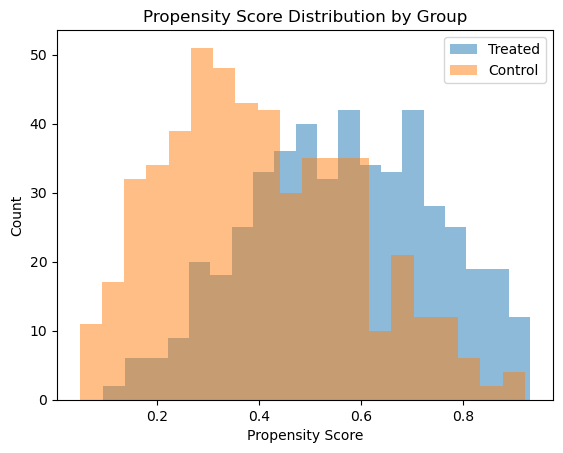

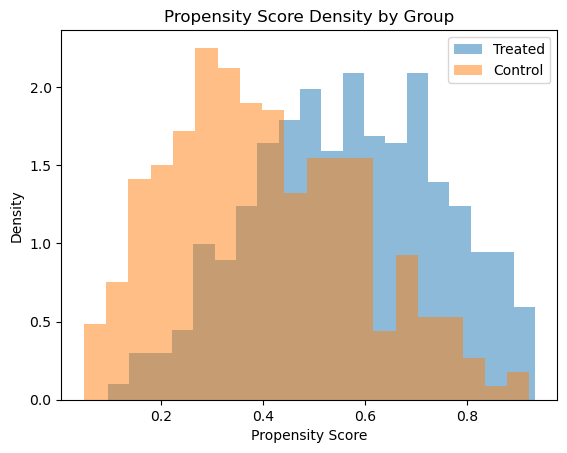

In [4]:
import matplotlib.pyplot as plt

# Histogram (count)
plt.figure()
plt.hist(propensity_scores[X==1], bins=20, density=False, alpha=0.5, label='Treated')
plt.hist(propensity_scores[X==0], bins=20, density=False, alpha=0.5, label='Control')
plt.legend()
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.title('Propensity Score Distribution by Group')
plt.show()

# “Density” version
plt.figure()
plt.hist(propensity_scores[X==1], bins=20, density=True, alpha=0.5, label='Treated')
plt.hist(propensity_scores[X==0], bins=20, density=True, alpha=0.5, label='Control')
plt.legend()
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Density by Group')
plt.show()

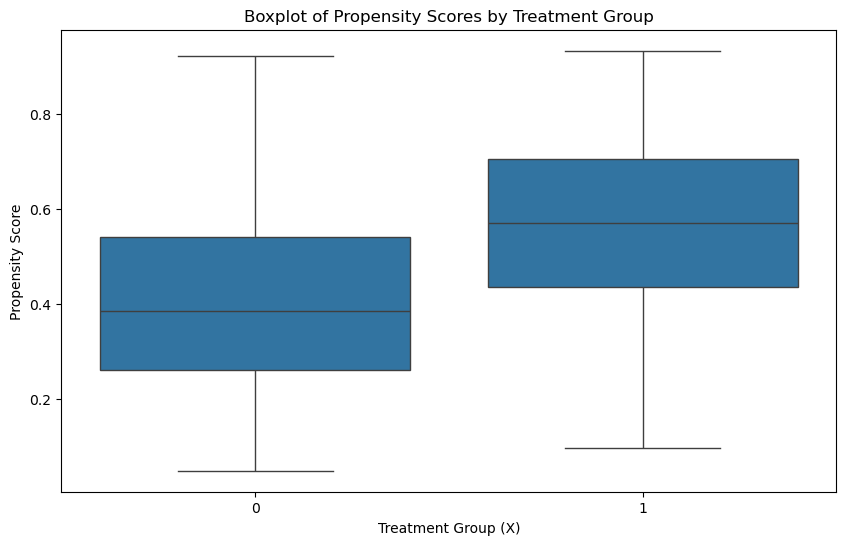

In [5]:
import seaborn as sns
# Boxplot of propensity scores
plt.figure(figsize=(10, 6))
sns.boxplot(x=X, y=propensity_scores)
plt.xlabel('Treatment Group (X)')
plt.ylabel('Propensity Score')
plt.title('Boxplot of Propensity Scores by Treatment Group')
plt.show()

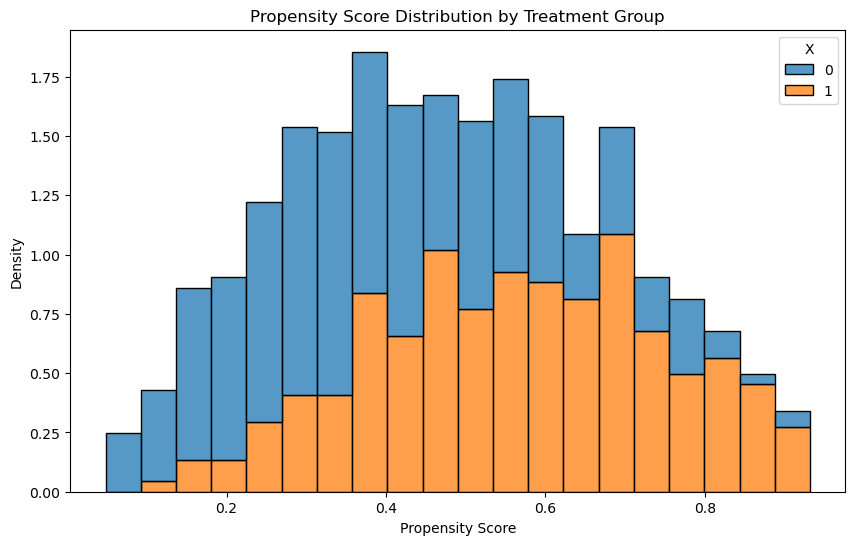

In [26]:
# sns histplot of propensity scores grouped by treatment
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x=propensity_scores, hue=X, multiple="stack", stat='density', bins=20)
plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Distribution by Treatment Group')
plt.show()

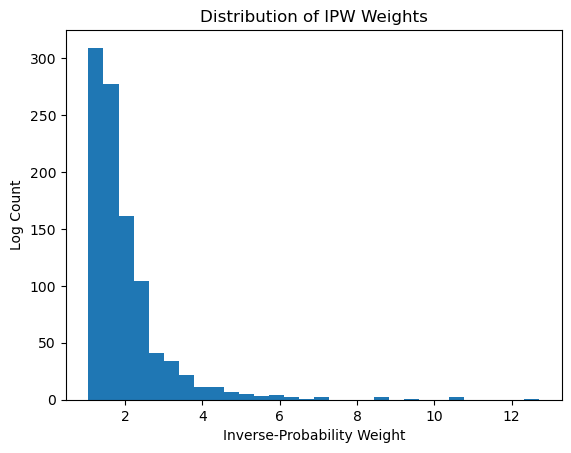

In [27]:
plt.figure()
plt.hist(weights, bins=30)
plt.xlabel('Inverse‐Probability Weight')
plt.ylabel('Log Count')
plt.title('Distribution of IPW Weights')
plt.show()

In [15]:
df

,X,Y,Z
0,1,4.109218,1.764052
1,0,2.259504,0.400157
2,0,-0.647584,0.978738
3,0,2.106071,2.240893
4,1,3.583464,1.867558
...,...,...,...
995,1,1.757928,0.412871
996,1,0.631199,-0.198399
997,0,1.104620,0.094192
998,0,-0.651432,-1.147611


<Axes: ylabel='Count'>

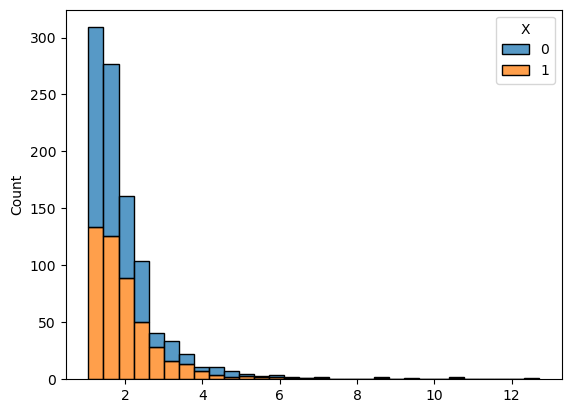

In [16]:
sns.histplot(data=df, x=weights, hue=X, multiple="stack", bins=30)

In [20]:
df['propensity_scores'] = propensity_scores

In [21]:
df.head()

,X,Y,Z,propensity_scores
0,1,4.109218,1.764052,0.840114
1,0,2.259504,0.400157,0.584646
2,0,-0.647584,0.978738,0.711082
3,0,2.106071,2.240893,0.892793
4,1,3.583464,1.867558,0.853089


<Axes: xlabel='Z', ylabel='Y'>

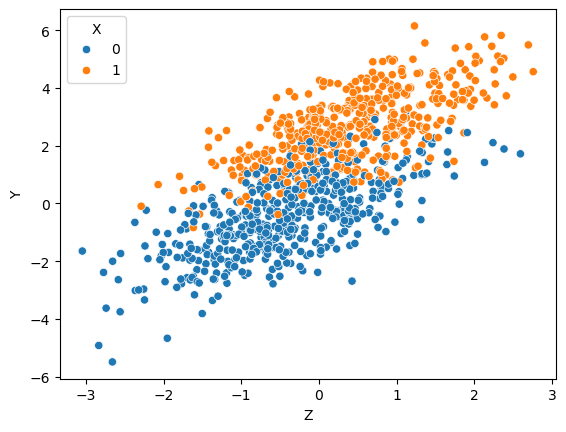

In [23]:
sns.scatterplot(x=df['Z'], y=df['Y'], hue=df['X'])

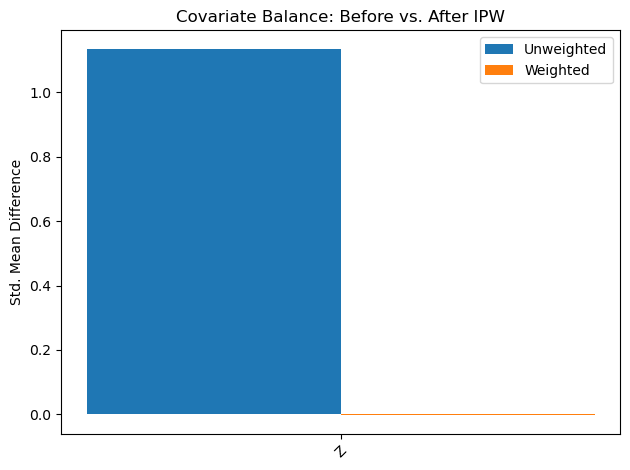

In [10]:
import numpy as np

def std_mean_diff(var):
    # unweighted difference
    diff_un = df.loc[X==1, var].mean() - df.loc[X==0, var].mean()
    pooled_sd  = np.sqrt(0.5*(df[var].var()))
    smd_un = diff_un / pooled_sd
    
    # weighted means
    m1 = np.average(df.loc[X==1, var], weights=weights[X==1])
    m0 = np.average(df.loc[X==0, var], weights=weights[X==0])
    smd_w = (m1 - m0) / pooled_sd
    return smd_un, smd_w

covariates = Z.columns
smds = [std_mean_diff(v) for v in covariates]
smd_un, smd_w = zip(*smds)

x = np.arange(len(covariates))
width = 0.35

plt.figure()
plt.bar(x - width/2, smd_un, width, label='Unweighted')
plt.bar(x + width/2, smd_w,  width, label='Weighted')
plt.xticks(x, covariates, rotation=45)
plt.ylabel('Std. Mean Difference')
plt.title('Covariate Balance: Before vs. After IPW')
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
plt.figure()
plt.scatter(df.loc[X==0,'Z1'], df.loc[X==0,'Z2'], marker='o', s=20, alpha=0.5, label='Control')
plt.scatter(df.loc[X==1,'Z1'], df.loc[X==1,'Z2'], marker='x', s=20, alpha=0.5, label='Treated')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.title('Covariate Scatter: Treated vs. Control')
plt.legend()
plt.show()

KeyError: 'Z1'

<Figure size 640x480 with 0 Axes>

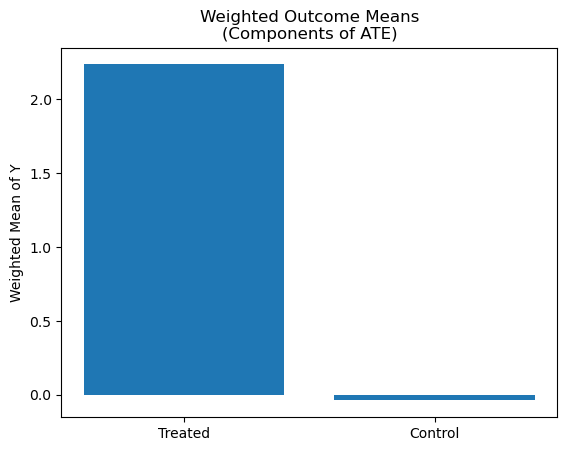

In [13]:
mu_t = np.sum(weights * X * Y) / np.sum(weights * X)
mu_c = np.sum(weights * (1 - X) * Y) / np.sum(weights * (1 - X))

plt.figure()
plt.bar(['Treated','Control'], [mu_t, mu_c])
plt.ylabel('Weighted Mean of Y')
plt.title('Weighted Outcome Means\n(Components of ATE)')
plt.show()

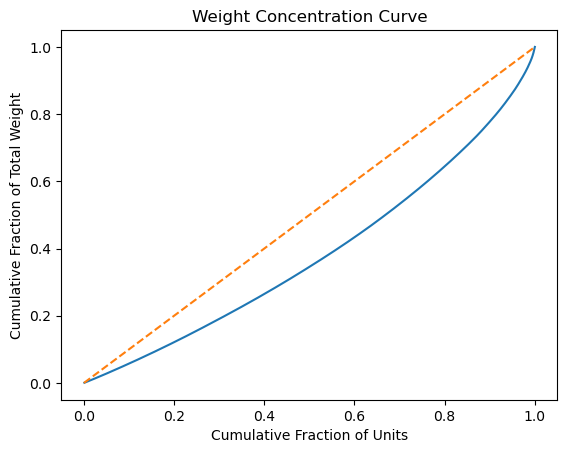

In [14]:
sorted_w = np.sort(weights)
cum_w = np.cumsum(sorted_w) / np.sum(sorted_w)
frac_units = np.arange(1, len(weights)+1) / len(weights)

plt.figure()
plt.plot(frac_units, cum_w)
plt.plot([0,1],[0,1], linestyle='--')  # 45° line
plt.xlabel('Cumulative Fraction of Units')
plt.ylabel('Cumulative Fraction of Total Weight')
plt.title('Weight Concentration Curve')
plt.show()

In [4]:
df['propensity_score'] = model.predict_proba(df[['Z']])[:, 1] # 0 and 1 are probabilities of false and of true

In [5]:
df['propensity_score'][:3]

0    0.840114
1    0.584646
2    0.711082
Name: propensity_score, dtype: float64

Estimating Propensity Scores:

In [6]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

# 1. Load the data
df = pd.read_csv('homework_8.2.csv', index_col=0)

# 2. Inspect columns
print("Columns:", df.columns.tolist())

# 3. Build covariate matrix and inverse covariance
Z = df[['Z1', 'Z2']].values
cov = np.cov(Z, rowvar=False)      # 2x2 covariance of Z1, Z2
VI = np.linalg.inv(cov)           # inverse covariance matrix

# 4. Split treated and control
treated = df[df['X'] == 1].reset_index(drop=True)
control = df[df['X'] == 0].reset_index(drop=True)

# 5. Compute Mahalanobis distances (treated x control)
treated_z = treated[['Z1', 'Z2']].values
control_z = control[['Z1', 'Z2']].values
dist_matrix = cdist(treated_z, control_z, metric='mahalanobis', VI=VI)

# 6. For each treated, find nearest control (with replacement)
nearest_idx = np.argmin(dist_matrix, axis=1)

# 7. Compute matched outcomes and ATE
treated_y = treated['Y'].values
control_y = control['Y'].values
matched_control_y = control_y[nearest_idx]

ATE = np.mean(treated_y - matched_control_y)

print(f"\nAverage Treatment Effect (1-to-1 Mahalanobis matching, with replacement): {ATE:.4f}")

Columns: ['X', 'Y', 'Z1', 'Z2']

Average Treatment Effect (1-to-1 Mahalanobis matching, with replacement): 3.4377


In [7]:
# Build inverse covariance for Z1, Z2
Z = df[['Z1', 'Z2']].values
VI = np.linalg.inv(np.cov(Z, rowvar=False))

# Separate treated and control
treated = df[df['X'] == 1].reset_index(drop=True)
control = df[df['X'] == 0].reset_index(drop=True)

# Extract covariates
treated_z = treated[['Z1', 'Z2']].values
control_z = control[['Z1', 'Z2']].values

# Compute Mahalanobis distance matrix
dist_matrix = cdist(treated_z, control_z, metric='mahalanobis', VI=VI)

# Find nearest control for each treated
nearest_idx = np.argmin(dist_matrix, axis=1)
nearest_dist = dist_matrix[np.arange(len(treated_z)), nearest_idx]

# Identify treated unit with least common support
farthest_treated_idx = np.argmax(nearest_dist)
matched_control_idx = nearest_idx[farthest_treated_idx]

# Retrieve values
treated_point = treated_z[farthest_treated_idx]
matched_control_point = control_z[matched_control_idx]

print(f"Treated unit index (in treated set) with least support: {farthest_treated_idx}")
print(f"  -> Treated Z1, Z2: {treated_point}")
print(f"Nearest control unit index (in control set): {matched_control_idx}")
print(f"  -> Control Z1, Z2: {matched_control_point}")

Treated unit index (in treated set) with least support: 241
  -> Treated Z1, Z2: [2.69622405 0.53815549]
Nearest control unit index (in control set): 217
  -> Control Z1, Z2: [ 1.51999486 -1.28220794]
